## DataLoader.ipynb

This notebook prepares the dataset for a food image classification task using TensorFlow and Keras. The main steps include:

- Extracting a zipped dataset containing images of food items.
- Limiting the dataset to 5 specific classes: `soup`, `dairy`, `dessert`, `meat`, and `vegfruit`.
- Trimming the number of images per class to a maximum of 100 to create a manageable subset.
- Using `image_dataset_from_directory` to create training and validation datasets with one-hot encoded labels.
- Displaying a sample of the images to verify successful loading.
- Applying basic data augmentation techniques to the training set using Keras preprocessing layers.

This notebook serves as the foundation for training a transfer learning model in a separate notebook.
The cleaned and preprocessed dataset will be reused in the `TrainBaseModel.ipynb` notebook for training a transfer learning model.


In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt


In [3]:
import zipfile

with zipfile.ZipFile("food_6.zip", "r") as zip_ref:
    zip_ref.extractall("food_6")


In [4]:
import os

data_dir = "food_6"
print("Classes found:", os.listdir(data_dir))


Classes found: ['soup', 'dairy', 'dessert', 'meat', 'vegfruit']


In [5]:
import os

data_dir = "food_6" 
max_images = 100
deleted = 0

for folder in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder)
    if not os.path.isdir(folder_path):
        continue

    files = os.listdir(folder_path)
    if len(files) > max_images:
        for fname in files[max_images:]:
            os.remove(os.path.join(folder_path, fname))
            deleted += 1

print(f"Deleted {deleted} extra images.")


Deleted 80 extra images.


In [6]:
image_size = (180, 180)
batch_size = 10

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "food_6",                      
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode="categorical"  # One-hot labels

)


Found 500 files belonging to 5 classes.
Using 400 files for training.
Using 100 files for validation.


2025-07-12 01:05:34.746113: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


### Visualization

2025-07-12 01:05:41.101343: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


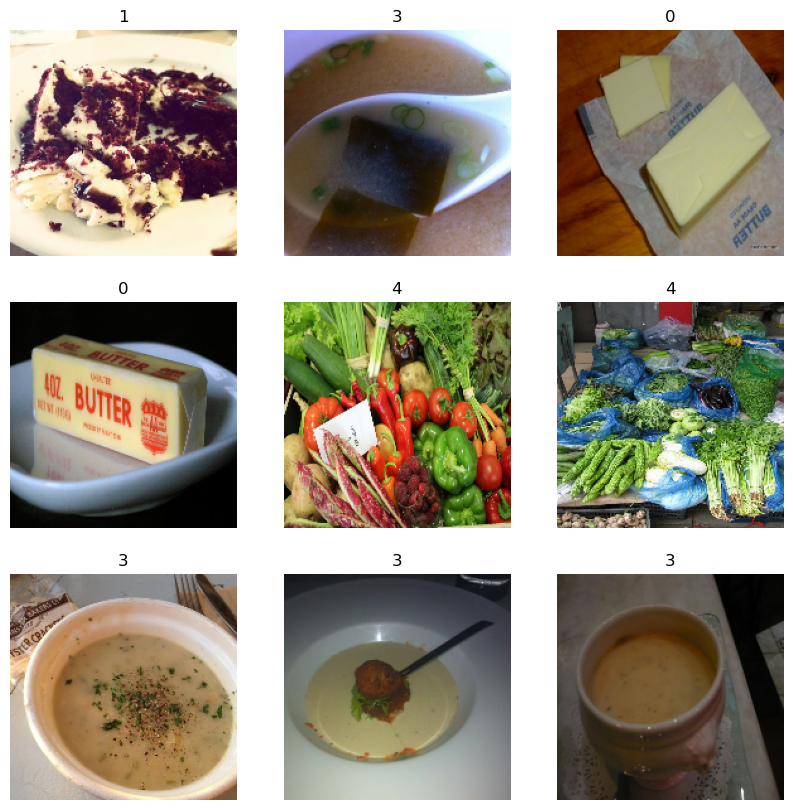

In [7]:


plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(np.argmax(labels[i]))  
        plt.axis("off")


In [8]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

2025-07-12 01:25:52.930207: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


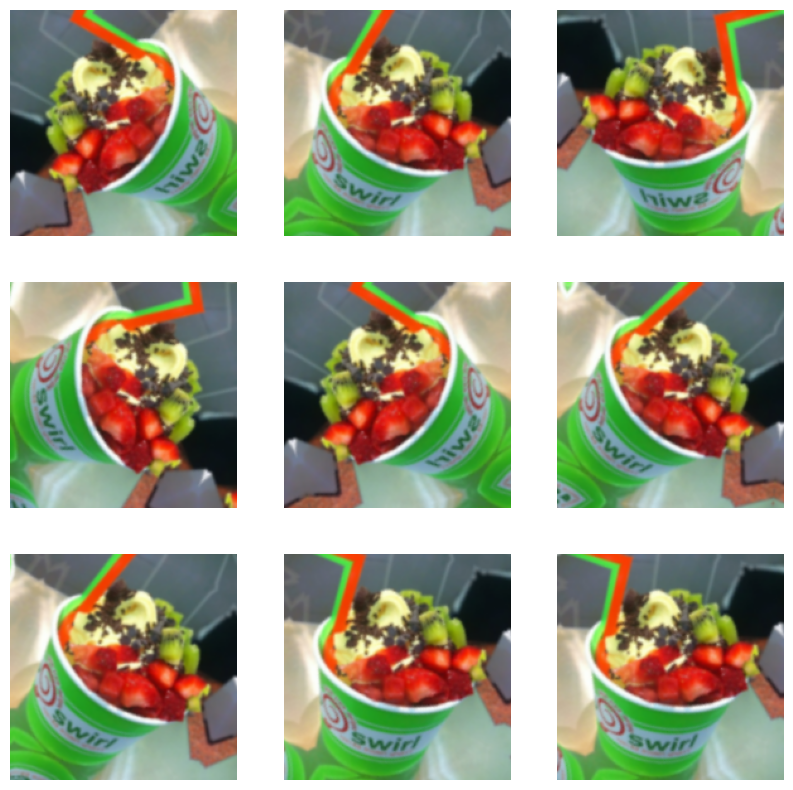

In [37]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

In [29]:
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

In [15]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Residual connection
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(previous_block_activation)
        x = layers.add([x, residual])
        previous_block_activation = x

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.25)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs, outputs)


In [18]:
image_size = (180, 180)
num_classes = 5  
model = make_model(input_shape=image_size + (3,), num_classes=num_classes)


In [19]:
epochs = 8

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]

model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.CategoricalCrossentropy(from_logits=False),  # Softmax output
    metrics=["accuracy"]
)

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)


Epoch 1/8
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3676 - loss: 1.4898

E0000 00:00:1752300677.419433     399 meta_optimizer.cc:967] remapper failed: INVALID_ARGUMENT: Mutation::Apply error: fanout 'StatefulPartitionedCall/functional_1_1/add_5_1/Add' exist for missing node 'StatefulPartitionedCall/functional_1_1/add_4_1/Add'.


40/40 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.3687 - loss: 1.4878 - val_accuracy: 0.1900 - val_loss: 1.6162
Epoch 2/8
40/40 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.4592 - loss: 1.3301 - val_accuracy: 0.1900 - val_loss: 1.6267
Epoch 3/8
40/40 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.5074 - loss: 1.1999 - val_accuracy: 0.1900 - val_loss: 1.6514
Epoch 4/8
40/40 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.5442 - loss: 1.0913 - val_accuracy: 0.1900 - val_loss: 1.6956
Epoch 5/8
40/40 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.5469 - loss: 1.1096 - val_accuracy: 0.1900 - val_loss: 1.7783
Epoch 6/8
40/40 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.6290 - loss: 1.0068 - val_accuracy: 0.1900 - val_loss: 1.8854
Epoch 7/8
40/40 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.5846 - loss: 0.9713 - val_accuracy: 0.1900 - val_loss: 2.0719
Epoch 8/8
40/40 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.6530 - loss: 0.9438 - val_accuracy: 0.1900 - val_loss: 2.3649


### Mterics

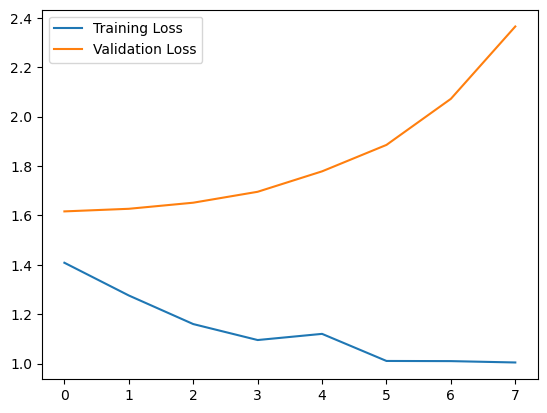

In [20]:
plt.plot(range(len(history.history["loss"])),history.history["loss"],label="Training Loss")
plt.plot(range(len(history.history["val_loss"])),history.history["val_loss"],label="Validation Loss")
plt.legend()

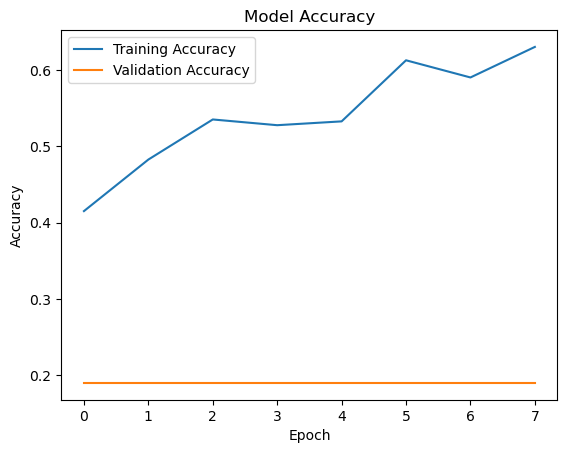

In [22]:
# Plot accuracy
plt.plot(range(len(history.history["accuracy"])), history.history["accuracy"], label="Training Accuracy")
plt.plot(range(len(history.history["val_accuracy"])), history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()
